In [9]:
import numpy as np
import pandas as pd
import load_data as ld
import preprocess as pre
from numpy.linalg import norm
import networkx as nx
import operator
import dijkstra as d
import kruskal as k
import PFNET
from textrank import KeywordSummarizer

class KnowledgeGraph:
    
    def __init__(self, title, n_node, scale, edge_option, word_option, cut_option, r):
        self.e_option = edge_option
        self.w_option = word_option
        self.scale = scale
        self.n_node = n_node
        self.paras = ld.read_txt(title + ".txt")
        
        self.nodes = self.get_nodes()
        self.edges = self.get_adj()
        self.G = self.make_graph(self.nodes, self.edges)
        self.cut_G = self.cutting_edge(self.G, self.edges, r, cut_option)
    
    def cos_similarity(self, lst1, lst2):
        return np.dot(lst1, lst2)/(np.linalg.norm(lst1)*np.linalg.norm(lst2))

    def rescale(self, num):
        return self.scale - (self.scale-1)*num

    def get_top_N(self, dict):
        tmp_dict = {}
        sorted_dict = sorted(dict.items(), key=operator.itemgetter(1), reverse=True)[:self.n_node]
        #print("dict : ", dict)
        '''
        tmp_dict['카테친'] = dict['카테친'] 
        tmp_dict['추출물'] = dict['추출물'] 
        tmp_dict['유도체'] = dict['유도체'] 
        tmp_dict['찻잎'] = dict['찻잎'] 
        tmp_dict['억제'] = dict['억제'] 
        tmp_dict['암세포'] = dict['암세포'] 
        tmp_dict['유로키나제'] = dict['유로키나제'] 
        tmp_dict['녹차'] = dict['녹차'] 
        tmp_dict['효능'] = dict['효능'] 
        tmp_dict['차'] = dict['차'] 
        tmp_dict['화학물질'] = dict['화학물질'] 
        tmp_dict['폴리페놀'] = dict['폴리페놀'] 
        tmp_dict['플라반올'] = dict['플라반올'] 
        tmp_dict['테아플라빈'] = dict['테아플라빈'] 
        
        tmp_dict['카테킨'] = dict['카테킨'] 
        tmp_dict['자일리톨'] = dict['자일리톨'] 
        tmp_dict['비타민'] = dict['비타민'] 
        tmp_dict['증상'] = dict['증상'] 
        tmp_dict['감염'] = dict['감염'] 
        tmp_dict['독감'] = dict['독감'] 
        tmp_dict['바이러스'] = dict['바이러스'] 
        tmp_dict['녹차'] = dict['녹차'] 
        tmp_dict['섭취'] = dict['섭취'] 
        tmp_dict['차'] = dict['차'] 
        tmp_dict['알파파'] = dict['알파파'] 
        tmp_dict['데아닌'] = dict['데아닌'] 
        tmp_dict['이뇨작용'] = dict['이뇨작용'] 
        tmp_dict['감기'] = dict['감기'] 
        
        tmp_dict = sorted(tmp_dict.items(), key=operator.itemgetter(1), reverse=True)
        #print("tmp : ", tmp_dict)
        '''
        return sorted_dict
        
        
    def get_nodes(self):
        if self.w_option == "Term-Frequency":
            tokens_comb = pre.preprocess_node(self.paras)
            dic_comb = pre.make_dic_count(tokens_comb)
            return self.get_top_N(dic_comb) 
        elif self.w_option =="TextRank":
            keyword_extractor = KeywordSummarizer(
                tokenize = pre.mecab_tokenize,
                window = -1,
                verbose = False
            )
            dic_comb = []
            sents = " ".join(self.paras).split(". ")
            keywords = keyword_extractor.summarize(sents, topk=self.n_node)
            for word, rank in keywords:
                dic_comb.append((word, round(rank, 2)))
            return dic_comb
                
    def get_adj(self): #title, nodes, option, scale):
        
        tokens_paras, tokens_stcs = pre.preprocess_edge(self.paras) 
        dic_paras = list(map(pre.make_dic_count, tokens_paras))
        dic_stcs = list(map(pre.get_stcs_dic, tokens_stcs))
        
        tokens_stcs = sum(tokens_stcs, [])
        dic_stcs = sum(dic_stcs, [])
        
        def get_vector(dictList, keyword):
            vector = []
            for dic in dictList:
                if keyword in dic.keys():
                    vector.append(dic[keyword])
                else:
                    vector.append(0)
            return vector
        
        N = len(self.nodes)
        cotable = np.zeros((N, N))
        
        # tokens_stc : [['녹차', '속', '폴리페놀'], ['거리', '커피', '전문점', '녹차', '전문점'], ... ]
        # tokens_dic : [['녹차', '속', '폴리페놀'], ['거리', '커피', '전문점', '녹차', '전문점', '녹차', '곳', ... ], ... ]
        # dic_Stcs : [{'녹차': 1, '속': 1, '폴리페놀': 1}, {'거리': 1, '커피': 1, '전문점': 2, '녹차': 1},
        # dict_paras : [{'녹차': 1, '속': 1, '폴리페놀': 1}, {'거리': 1, '커피': 1, '전문점': 2, '녹차': 5, '곳': 1, ... ], ... ]        
        
        for i in range(N):
            for j in range(i+1, N):
                left, right = self.nodes[i][0], self.nodes[j][0]
                if self.e_option == "ss":
                    for stc in tokens_stcs:
                        if left in stc and right in stc:
                            cotable[i][j] += 1        
                elif self.e_option == "ps":
                    for para in tokens_paras:
                        if left in para and right in para:
                            cotable[i][j] += 1  
                elif self.e_option == "scs":
                    Lvector = get_vector(dic_stcs, left)
                    Rvector = get_vector(dic_stcs, right)
                    sim = self.cos_similarity(Lvector, Rvector)
                    if sim != 0:
                        cotable[i][j] = self.rescale(sim)
                elif self.e_option == "pcs":
                    Lvector = get_vector(dic_paras, left)
                    Rvector = get_vector(dic_paras, right)
                    sim = self.cos_similarity(Lvector, Rvector)
                    if sim != 0:
                        cotable[i][j] = self.rescale(sim)
                else:
                    print("error : choose option among ('ss', 'ps', 'scs', 'pcs')")
        #print("before cotable : ", cotable)
                    
        no_edge_idx = np.where(cotable == 0)
        
        if self.e_option == "ss" or self.e_option == "ps":
            maxvalue = np.max(cotable)
            cotable = self.rescale(cotable / maxvalue)
            for i in range(len(no_edge_idx[0])):
                cotable[no_edge_idx[0][i], no_edge_idx[1][i]] = -1
            
        for i in range(len(no_edge_idx[0])):
            cotable[no_edge_idx[0][i], no_edge_idx[1][i]] = -1
            
        cotable = np.round(cotable, 2)
        
        return cotable

    def make_graph(self, nodes, adj):
        G = nx.Graph()
        for i in range(len(nodes)):
            for j in range(i+1, len(nodes)):
                if adj[i][j] != -1:
                    nodei = str(nodes[i][0])+" "+str(nodes[i][1])
                    nodej = str(nodes[j][0])+" "+str(nodes[j][1])
                    G.add_edge(nodei, nodej, weight=adj[i][j])
        return G


    def cutting_edge(self, graph, adj, r, option):

        nodes = list(graph.nodes)
        n = len(nodes)
        newG = nx.Graph()
        id2name = {}
        for idx, name in enumerate(nodes):
            id2name[idx] = name           

        if option == "dijkstra":
            dist, parents = d.dijkstra(graph, r)
            for i in range(n):
                for j in range(i+1, n):
                    if dist[i][j] != float('inf'):
                        if dist[i][j] == adj[i][j]:
                            fromN, toN = id2name[i], id2name[j]
                            newG.add_edge(fromN, toN, weight=adj[i][j])

        elif option == "MST":
            parent = k.kruskal(graph, r)
            for p in range(len(parent)):
                fromN, toN = id2name[p], id2name[parent[p]]
                if fromN != toN:
                    newG.add_edge(fromN, toN, weight=adj[p][parent[p]])
                    
        elif option == "PFNET":
            if r == float("inf"):
                newG = PFNET.minimal_pathfinder(graph)
            else:
                newG = PFNET.minimal_pathfinder(graph, r)
                
        return newG

In [10]:
#title = "녹차의 효능"
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

title = "녹차 속 폴리페놀"
scale = 7
num_node = 14
edge_option = "scs"
#word_option = "Term-Frequency"
word_option = "TextRank"
cut_option = "PFNET"
r = float("inf")
KG = KnowledgeGraph(title, num_node, scale, edge_option, word_option, cut_option, r)

In [7]:
# 필요한 패키지와 라이브러리를 가져옴
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 그래프를 노트북 안에 그리기 위해 설정
%matplotlib inline

path = 'C:\\WINDOWS\\Fonts\\malgunbd.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family=font_name)

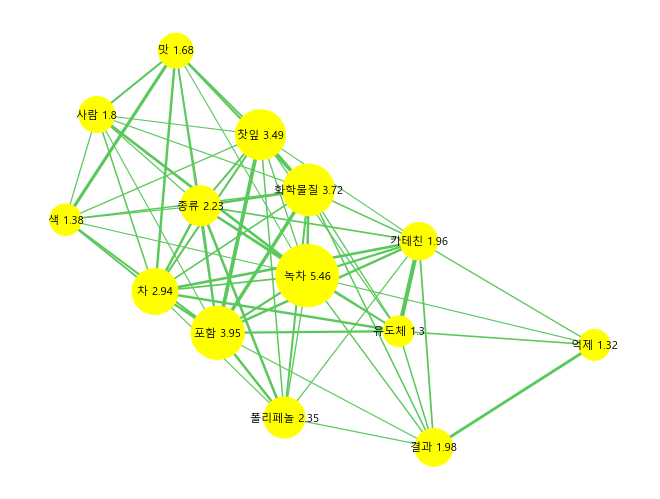

In [13]:
weights = nx.get_edge_attributes(KG.G, "weight")
edges = KG.G.edges()
nodeSize = [ float(t.split()[-1]) for t in list(KG.G.nodes) ]
nodeSize = nodeSize / np.max(nodeSize) * 2000 

scaling_factor = 0.6 # to emphasise differences 
alphas = [(scale - weights[edge] + 1) * scaling_factor for edge in edges]
colors = [rgb_to_hex((90, 200, 90)) for edge in edges]
#colors = [rgb_to_hex((int(75 * (weights[edge]/7))+180, int(140 * (1-weights[edge]/7))+70, 0  )) for edge in edges]
#nx.draw_shell(G, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, width=alphas, with_labels=True, font_family=font_name)
nx.draw_spring(KG.G, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, width=alphas, with_labels=True, font_family=font_name)

#pos=nx.spring_layout(G)
#nx.draw_networkx(G, pos=pos, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, width=alphas, with_labels=True, font_family=font_name)
#labels = nx.get_edge_attributes(G,'weight')
#nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels, font_size=6)

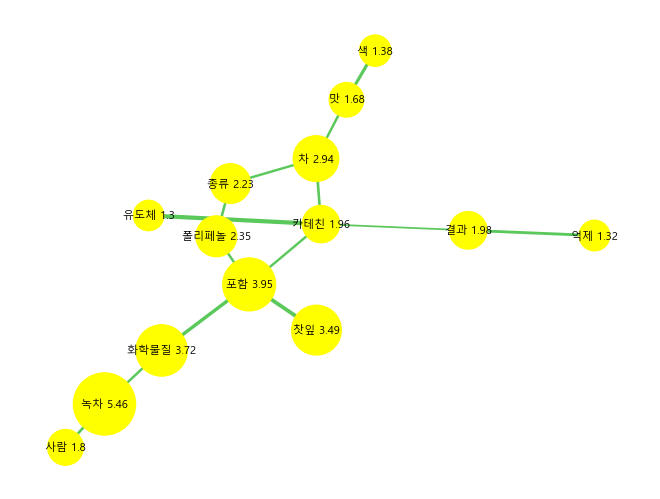

In [14]:
weights = nx.get_edge_attributes(KG.cut_G, "weight")
edges = KG.cut_G.edges()
nodeSize = [ float(t.split()[-1]) for t in list(KG.cut_G.nodes) ]
nodeSize = nodeSize / np.max(nodeSize) * 2000 

scaling_factor = 0.6 # to emphasise differences 
alphas = [(scale - weights[edge] + 1) * scaling_factor for edge in edges]
colors = [rgb_to_hex((90, 200, 90)) for edge in edges]
#colors = [rgb_to_hex((int(75 * (weights[edge]/7))+180, int(140 * (1-weights[edge]/7))+70, 0  )) for edge in edges]
#nx.draw_shell(cut_G, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, width=alphas, with_labels=True, font_family=font_name)
nx.draw_spring(KG.cut_G, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, width=alphas, with_labels=True, font_family=font_name)

#pos=nx.spring_layout(cut_G)
#nx.draw_networkx(cut_G, pos=pos, edge_color=colors, node_color='yellow', node_size=nodeSize, font_size=8, with_labels=True, font_family=font_name)
#labels = nx.get_edge_attributes(cut_G,'weight')
#nx.draw_networkx_edge_labels(cut_G, pos=pos, edge_labels=labels, font_size=6)

In [18]:
KG.cut_G.degree

DegreeView({'녹차 28': 1, '포함 19': 4, '찻잎 16': 1, '차 16': 2, '화학물질 16': 2, '폴리페놀 13': 2, '종류 12': 1, '카테친 11': 2, '결과 9': 2, '홍차 7': 1, '물 7': 4, '맛 7': 2, '색 7': 3, '암세포 7': 1})

In [19]:
KG.G.degree

DegreeView({'녹차 28': 13, '포함 19': 12, '찻잎 16': 11, '차 16': 10, '화학물질 16': 12, '폴리페놀 13': 8, '종류 12': 11, '카테친 11': 9, '결과 9': 6, '홍차 7': 8, '물 7': 10, '맛 7': 9, '색 7': 9, '암세포 7': 2})

In [20]:
for (u, v, w) in KG.G.edges(data=True):
    if '독감' in u:
        print("u, v, w : ", u, v, w['weight'])

In [21]:
for (u, v, w) in KG.cut_G.edges(data=True):
    print("u, v, w : ", u, v, w['weight'])

u, v, w :  녹차 28 화학물질 16 5.04
u, v, w :  포함 19 찻잎 16 3.46
u, v, w :  포함 19 화학물질 16 3.92
u, v, w :  포함 19 폴리페놀 13 5.06
u, v, w :  포함 19 물 7 4.64
u, v, w :  차 16 카테친 11 4.87
u, v, w :  차 16 물 7 4.33
u, v, w :  폴리페놀 13 종류 12 4.93
u, v, w :  카테친 11 결과 9 5.91
u, v, w :  결과 9 암세포 7 6.4
u, v, w :  홍차 7 색 7 3.12
u, v, w :  물 7 맛 7 4.48
u, v, w :  물 7 색 7 4.48
u, v, w :  맛 7 색 7 4.23
